In [0]:
import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
#import lightgbm as lgb
import warnings
#from tabulate import tabulate

import plotly.graph_objs as go
import plotly
import plotly.offline as pyo

import sys
import statsmodels.api as sm
from sklearn.model_selection import TimeSeriesSplit

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
warnings.filterwarnings('ignore')

# BASIC HOUSEKEEPING FUNCTIONS

In [0]:
'''
This script aims to define custom exception for exception handling purposes. It will be easier to identify errors and issues.
'''

'''
Importing the libraries.
'''

# Debugging and verbose.
import sys


def detailed_error_msg(error, error_details: sys):
    '''
    Generate a detailed error message including file name, line number, and error message.
    
    Args:
        error: The original error or exception.
        error_details (sys): System information about the error.
        
    Returns:
        str: A detailed error message.
    '''
    _, _, exception_traceback = error_details.exc_info()
    file_name = exception_traceback.tb_frame.f_code.co_filename
    line_number = exception_traceback.tb_lineno
    detailed_error_message = f'An error occurred in python file [{file_name}] line number [{line_number}] error message [{str(error)}]'
    
    return detailed_error_message


class CustomException(Exception):
    '''
    Custom exception class with detailed error information.
    '''
    def __init__(self, detailed_error_message: str, error_details: sys) -> None:
        '''
        Initialize a DetailedException instance.

        Args:
            detailed_error_message (str): The detailed error message.
            error_details (sys): System information about the error.
        '''
        super().__init__(detailed_error_message)
        self.detailed_error_message = detailed_error_msg(detailed_error_message, error_details=error_details)


    def __str__(self) -> str:
        '''
        Convert the exception to a string representation.
        
        Returns:
            str: The detailed error message.
        '''
        return self.detailed_error_message
    

In [0]:
def create_time_series_features(data, target, to_sort=None, to_group=None, lags=None, windows=None, weights=None, min_periods=None, win_type=None, date_related=True, lag=False, log_transformation=False, roll=False, ewm=False, roll_mean=False, roll_std=False, roll_min=False, roll_max=False):
    '''
    Create time-series features from the given data.

    Args:
        data (DataFrame): The input data containing time-series information.
        target (str): The name of the target variable.
        to_sort (str, optional): The column name used for sorting the data. Defaults to None.
        to_group (str, optional): The column name used for grouping data. Defaults to None.
        lags (list of int, optional): List of lag values for creating lag features. Defaults to None.
        windows (list of int, optional): List of window sizes for creating rolling window features. Defaults to None.
        weights (list of float, optional): List of weights for creating exponentially weighted mean features. Defaults to None.
        min_periods (int, optional): The minimum number of observations required to have a value. Defaults to None.
        win_type (str, optional): The window type for rolling window calculations. Defaults to None.
        date_related (bool, optional): Flag indicating whether to create date-related features. Defaults to True.
        lag (bool, optional): Flag indicating whether to create lag features. Defaults to False.
        log_transformation (bool, optional): Flag indicating whether to apply log transformation to the target variable. Defaults to False.
        roll (bool, optional): Flag indicating whether to create rolling window features. Defaults to False.
        ewm (bool, optional): Flag indicating whether to create exponentially weighted mean features. Defaults to False.
        roll_mean (bool, optional): Flag indicating whether to create rolling mean features. Defaults to False.
        roll_std (bool, optional): Flag indicating whether to create rolling standard deviation features. Defaults to False.
        roll_min (bool, optional): Flag indicating whether to create rolling minimum features. Defaults to False.
        roll_max (bool, optional): Flag indicating whether to create rolling maximum features. Defaults to False.

    Returns:
        DataFrame: DataFrame containing the original data with additional time-series features.

    Raises:
        CustomException: If an exception occurs during feature creation.
    '''
    try:
        df = data.copy()

        # Create date-related features.
        if date_related:
            df['dayofweek'] = df.index.dayofweek
            df['quarter'] = df.index.quarter
            df['month'] = df.index.month
            df['year'] = df.index.year
            df['dayofyear'] = df.index.dayofyear
            df['dayofmonth'] = df.index.day
            df['weekofyear'] = df.index.isocalendar().week.astype(np.float64)
            df['is_wknd'] = df.index.weekday // 4
            df['is_month_start'] = df.index.is_month_start.astype(int)
            df['is_month_end'] = df.index.is_month_end.astype(int)

        # Apply log_transformation to the target variable.
        if log_transformation:
            df[target] = np.log1p(df[target])
        
        # Create lag features.
        if lag:
            df.sort_values(by=to_sort, axis=0, inplace=True)
            for lag in lags:
                df['sales_lag_' + str(lag)] = df.groupby(to_group)[target].transform(lambda x: x.shift(lag))
        
        # Create rolling window features.
        if roll:
            df.sort_values(by=to_sort, axis=0, inplace=True)

            if roll_mean:
                for window in windows:
                    df['sales_roll_mean_' + str(window)] = df.groupby(to_group)[target].transform(lambda x: x.shift(1).rolling(window=window, min_periods=min_periods, win_type=win_type).mean())
            if roll_std:
                for window in windows:
                    df['sales_roll_std_' + str(window)] = df.groupby(to_group)[target].transform(lambda x: x.shift(1).rolling(window=window, min_periods=min_periods, win_type=win_type).std())
            if roll_min:
                for window in windows:
                    df['sales_roll_min_' + str(window)] = df.groupby(to_group)[target].transform(lambda x: x.shift(1).rolling(window=window, min_periods=min_periods, win_type=win_type).min())
            if roll_max:
                for window in windows:
                    df['sales_roll_max_' + str(window)] = df.groupby(to_group)[target].transform(lambda x: x.shift(1).rolling(window=window, min_periods=min_periods, win_type=win_type).max())

        # Create exponentially weighted mean features.
        if ewm:
            for weight in weights:
                    for lag in lags:
                        df['sales_ewm_w_' + str(weight) + '_lag_' + str(lag)] = df.groupby(to_group)[target].transform(lambda x: x.shift(lag).ewm(alpha=weight).mean())
            
        return df

    except Exception as e:
        raise CustomException(e, sys)

def time_series_split(data, cutoff_date):
    '''
    Splits the time series data into train and test sets on a chronological order based on the cutoff date.

    Args:
    data (pandas.DataFrame): The time series data to be split.
    cutoff_date (str or datetime): The date that separates the training and test sets.

    Raises:
    CustomException: An error occurred during the time series split.

    Returns:
    tuple: A tuple containing two pandas.DataFrame objects, where the first one represents the training set
    with data before the cutoff date, and the second one represents the test set with data on and after the cutoff date.
    '''
    try:
        train = data.loc[data.index < cutoff_date]
        test = data.loc[data.index >= cutoff_date]
        return train, test
    
    except Exception as e:
        raise CustomException(e, sys)
    

def plot_time_series_split(train, test, cutoff_date):
    '''
    Plots the time series data after splitting into train and test sets.

    Args:
    train (pandas.DataFrame): The training data to be plotted.
    test (pandas.DataFrame): The test data to be plotted.
    cutoff_date (str or datetime): The date that separates the training and test sets.

    Raises:
    CustomException: An error occurred during the plotting process.
    '''
    try:
        figure, ax = plt.subplots(figsize=(20, 7))

        train.plot(ax=ax, label='Train', y='sales')
        test.plot(ax=ax, label='Test', y='sales')

        ax.axvline(cutoff_date, color='black', ls='--')

        plt.title('Time-series-train-test-split', fontsize=25, fontweight='bold', loc='left', pad=25)
        plt.xlabel('Date', loc='left', labelpad=25)
        plt.ylabel('Sales', loc='top', labelpad=25)
        plt.xticks(rotation=0)
        plt.legend(loc='upper left')
        plt.show()
    
    except Exception as e:
        raise CustomException(e, sys)


    import plotly.graph_objects as go

def plot_time_series_split_plotly(train, test, cutoff_date):
    '''
    Plots the time series data after splitting into train and test sets using Plotly.

    Args:
    train (pandas.DataFrame): The training data to be plotted.
    test (pandas.DataFrame): The test data to be plotted.
    cutoff_date (str or datetime): The date that separates the training and test sets.

    Raises:
    CustomException: An error occurred during the plotting process.
    '''
    try:
        # Create traces for the train and test data
        trace_train = go.Scatter(
            x=train.index,
            y=train['sales'],
            mode='lines',
            name='Train'
        )

        trace_test = go.Scatter(
            x=test.index,
            y=test['sales'],
            mode='lines',
            name='Test'
        )

        # Create a layout for the plot
        layout = go.Layout(
            title='Time Series Train-Test Split',
            xaxis=dict(title='Date'),
            yaxis=dict(title='Sales'),
            legend=dict(orientation='h', x=0.5, y=1.2)
        )

        # Create a figure with the traces and layout
        fig = go.Figure(data=[trace_train, trace_test], layout=layout)

        # Update the layout to add a vertical line at the cutoff date
        fig.add_shape(
            type='line',
            x0=cutoff_date,
            y0=0,
            x1=cutoff_date,
            y1=1,
            line=dict(color='black', width=2),
            xref='x',
            yref='paper'
        )

        # Show the plot
        fig.show()
        # Get the HTML representation of the figure
        fig_html = pyo.plot(fig, output_type='div', include_plotlyjs=False)

        # Share the HTML representation using a custom API call
        restworkflowcontext.outPlotly(9, title="TIME SERIES TRAIN-TEST SPLIT", text=fig_html)

    except Exception as e:
        raise CustomException(e, sys)

In [0]:
#SET GLOBAL FLAG
should_continue_execution = True  # Default to True

In [0]:
#Widgets used to pass value
dbutils.widgets.text("job-id", "100")
dbutils.widgets.text("postback-url", "")
dbutils.widgets.text("rb_detail", "")
dbutils.widgets.text("rb_summary", "")
dbutils.widgets.text("rb_detail_org", "")

#dbutils.widgets.text("bt_insights", "N")

jobId = dbutils.widgets.get("job-id")
rb_detail = dbutils.widgets.get("rb_detail")
rb_features = dbutils.widgets.get("rb_detail")
rb_detail_org = dbutils.widgets.get("rb_detail_org")
if rb_detail_org == '3':
    rb_detail = '3'
rb_summary = dbutils.widgets.get("rb_summary")
webserverURL = dbutils.widgets.get("postback-url")
bt_insights = rb_detail
#print(f"parameter_value for key rb_summary is: {rb_summary} and parameter_value for key rb_detail is: {rb_detail}")
#print(f"parameter_value for key rb_features is: {rb_features}")
#Initialize and Start Execution
from fire_notebook.output.workflowcontext import RestWorkflowContext
restworkflowcontext = RestWorkflowContext(webserverURL, jobId)
message="20"
restworkflowcontext.outputProgress(9, title="Progress", progress=message)

Sending Message: {"progress": "20", "id": 9, "name": "Progress", "title": "Progress", "type": "progress", "resultType": 3, "visibility": "EXPANDED", "time": "Oct 10, 2024 06:52:39 PM"}
Not sending message to fire_notebook server as the post back URL is not http

# Load Data & run TS Decomposition & Sales Visuals 

In [0]:
#data_path = '/dbfs/FileStore/Demand-Forecasting/Input/demand-train.csv'
data_path = '/dbfs/FileStore/Demand-Forecasting/Input/demand_forecasting.csv'
df2 = pd.read_csv(data_path)
df2['date'] = pd.to_datetime(df2['date'])
df2.set_index('date', inplace=True)
df2.sort_values(by=['date', 'store', 'item'], inplace=True)

print(f'The data goes from {df2.index.min()} to {df2.index.max()}.')

The data goes from 2013-01-01 00:00:00 to 2017-12-31 00:00:00.

In [0]:
CUTOFF_DATE = '2017-01-01'

#df2 = df2.sample(frac=0.1)
df2 = create_time_series_features(data=df2, target='sales', date_related=True)

#Sample data

train2, test2 = time_series_split(df2, CUTOFF_DATE)
print(f'Train shape: {train2.shape}. Train data goes from {train2.index.min()} to {train2.index.max()}.')
print(f'Test shape: {test2.shape}. Train data goes from {test2.index.min()} to {test2.index.max()}.')
#visualize the time series train-test-split.
#plot_time_series_split(train2, test2, CUTOFF_DATE)

#train2_sample = train2.sample(frac=0.1)  # Sample 10% of the data
#test2_sample = test2.sample(frac=0.1)

plot_time_series_split_plotly(train2, test2, CUTOFF_DATE)
#plot_time_series_split_plotly(train2, test2, CUTOFF_DATE)


Train shape: (13149, 13). Train data goes from 2013-01-01 00:00:00 to 2016-12-31 00:00:00.
Test shape: (3285, 13). Train data goes from 2017-01-01 00:00:00 to 2017-12-31 00:00:00.

Check the Input type..
There is a match
 And Input is string type.
Sending Message: {'text': 'Plotly.newPlot( @@fdde9eff-11f6-417a-9571-8b94a9de44d3@@, [{@@mode@@:@@lines@@,@@name@@:@@Train@@,@@x@@:[@@2013-01-01T00:00:00@@,@@2013-01-01T00:00:00@@,@@2013-01-01T00:00:00@@,@@2013-01-01T00:00:00@@,@@2013-01-01T00:00:00@@,@@2013-01-01T00:00:00@@,@@2013-01-01T00:00:00@@,@@2013-01-01T00:00:00@@,@@2013-01-01T00:00:00@@,@@2013-01-02T00:00:00@@,@@2013-01-02T00:00:00@@,@@2013-01-02T00:00:00@@,@@2013-01-02T00:00:00@@,@@2013-01-02T00:00:00@@,@@2013-01-02T00:00:00@@,@@2013-01-02T00:00:00@@,@@2013-01-02T00:00:00@@,@@2013-01-02T00:00:00@@,@@2013-01-03T00:00:00@@,@@2013-01-03T00:00:00@@,@@2013-01-03T00:00:00@@,@@2013-01-03T00:00:00@@,@@2013-01-03T00:00:00@@,@@2013-01-03T00:00:00@@,@@2013-01-03T00:00:00@@,@@2013-01-03T00:00:00@@,@@2013-01-03T00:00:00@@,@@2013-01-04T00:00:00@@,@@2013-01-04T00:00:00@@,@@2013-01-04T00:00:00@@,@@2013-01-04T00:00:00@@,@@2013-01-04T00:00:00@@,@@2013-01-04T00:00:00@@,@@2013-01-04T00:00:00@@,@@2013-01-04T00:00:00@@,@@2013-01-04T00:00:00@@,@@2013-01-05T00:00:00@@,@@2013-01-05T00:00:00@@,@@2013-01-05T00:00:00@@,@@2013-01-05T00:00:00@@,@@2013-01-05T00:00:00@@,@@2013-01-05T00:00:00@@,@@2013-01-05T00:00:00@@,@@2013-01-05T00:00:00@@,@@2013-01-05T00:00:00@@,@@2013-01-06T00:00:00@@,@@2013-01-06T00:00:00@@,@@2013-01-06T00:00:00@@,@@2013-01-06T00:00:00@@,@@2013-01-06T00:00:00@@,@@2013-01-06T00:00:00@@,@@2013-01-06T00:00:00@@,@@2013-01-06T00:00:00@@,@@2013-01-06T00:00:00@@,@@2013-01-07T00:00:00@@,@@2013-01-07T00:00:00@@,@@2013-01-07T00:00:00@@,@@2013-01-07T00:00:00@@,@@2013-01-07T00:00:00@@,@@2013-01-07T00:00:00@@,@@2013-01-07T00:00:00@@,@@2013-01-07T00:00:00@@,@@2013-01-07T00:00:00@@,@@2013-01-08T00:00:00@@,@@2013-01-08T00:00:00@@,@@2013-01-08T00:00:00@@,@@2013-01-08T00:00:00@@,@@2013-01-08T00:00:00@@,@@2013-01-08T00:00:00@@,@@2013-01-08T00:00:00@@,@@2013-01-08T00:00:00@@,@@2013-01-08T00:00:00@@,@@2013-01-09T00:00:00@@,@@2013-01-09T00:00:00@@,@@2013-01-09T00:00:00@@,@@2013-01-09T00:00:00@@,@@2013-01-09T00:00:00@@,@@2013-01-09T00:00:00@@,@@2013-01-09T00:00:00@@,@@2013-01-09T00:00:00@@,@@2013-01-09T00:00:00@@,@@2013-01-10T00:00:00@@,@@2013-01-10T00:00:00@@,@@2013-01-10T00:00:00@@,@@2013-01-10T00:00:00@@,@@2013-01-10T00:00:00@@,@@2013-01-10T00:00:00@@,@@2013-01-10T00:00:00@@,@@2013-01-10T00:00:00@@,@@2013-01-10T00:00:00@@,@@2013-01-11T00:00:00@@,@@2013-01-11T00:00:00@@,@@2013-01-11T00:00:00@@,@@2013-01-11T00:00:00@@,@@2013-01-11T00:00:00@@,@@2013-01-11T00:00:00@@,@@2013-01-11T00:00:00@@,@@2013-01-11T00:00:00@@,@@2013-01-11T00:00:00@@,@@2013-01-12T00:00:00@@,@@2013-01-12T00:00:00@@,@@2013-01-12T00:00:00@@,@@2013-01-12T00:00:00@@,@@2013-01-12T00:00:00@@,@@2013-01-12T00:00:00@@,@@2013-01-12T00:00:00@@,@@2013-01-12T00:00:00@@,@@2013-01-12T00:00:00@@,@@2013-01-13T00:00:00@@,@@2013-01-13T00:00:00@@,@@2013-01-13T00:00:00@@,@@2013-01-13T00:00:00@@,@@2013-01-13T00:00:00@@,@@2013-01-13T00:00:00@@,@@2013-01-13T00:00:00@@,@@2013-01-13T00:00:00@@,@@2013-01-13T00:00:00@@,@@2013-01-14T00:00:00@@,@@2013-01-14T00:00:00@@,@@2013-01-14T00:00:00@@,@@2013-01-14T00:00:00@@,@@2013-01-14T00:00:00@@,@@2013-01-14T00:00:00@@,@@2013-01-14T00:00:00@@,@@2013-01-14T00:00:00@@,@@2013-01-14T00:00:00@@,@@2013-01-15T00:00:00@@,@@2013-01-15T00:00:00@@,@@2013-01-15T00:00:00@@,@@2013-01-15T00:00:00@@,@@2013-01-15T00:00:00@@,@@2013-01-15T00:00:00@@,@@2013-01-15T00:00:00@@,@@2013-01-15T00:00:00@@,@@2013-01-15T00:00:00@@,@@2013-01-16T00:00:00@@,@@2013-01-16T00:00:00@@,@@2013-01-16T00:00:00@@,@@2013-01-16T00:00:00@@,@@2013-01-16T00:00:00@@,@@2013-01-16T00:00:00@@,@@2013-01-16T00:00:00@@,@@2013-01-16T00:00:00@@,@@2013-01-16T00:00:00@@,@@2013-01-17T00:00:00@@,@@2013-01-17T00:00:00@@,@@2013-01-17T00:00:00@@,@@2013-01-17T00:00:00@@,@@2013-01-17T00:00:00@@,@@2013-01-17T00:00:00@@,@@2013-01-17T00:00:00@@,@@2013-01-17T00:00:00@@,@@2013-01-17T00:00:00@@,@@2013-01-18T00:00:00@@,@@2013-01-18T00:00:00@@,@@2013-01-18T00:00:00@@,@@2013-01-18T00:00:00@@,@@2013-01-18T00:00:00@@,@@2013-01

%md
### Time series decomposition
-  Time series data is a sequence of data points indexed in time order, typically at uniform intervals, used to track changes over time and analyze trends, patterns, and seasonal variations.
- A time series is stationary when its statistical characteristics, such as mean, variance and covariance don't change over time.
- Time series decomposition: Analyze time series data by breaking it down into components to understand the underlying patterns, trends and irregularities within the data.
- Trend, seasonal, cyclical and residual components.
- Trend Component: Underlying long-term progression or direction of the time series. Shows wheter the data is increasing, decreasing or remaining relatively constant over time.
- Seasonal Component: Regular, periodic fluctuations or patterns that occurs at specific intervals within the time series (annually, quarterly, monthly, and so on).
- Cyclical Component: Fluctuations in the time series that are not of a fixed period. Typically associated with business/economic cycles.
- Residual Component: Random fluctuations or irregularities that cannot be attributed to the trend, seasonal or cyclical patterns. Unexplained variability in the time series.
- In order to perform time series decomposition, I will use the statsmodels package, applying seasonal decomposition using moving averages.
- Moving Average: A moving average is a method that smooths data by creating averages from subsets of consecutive data points, providing a clearer picture of trends and patterns while reducing noise and short-term fluctuations.
- Approaches used to decompose a time series: Additive Model, Multiplicative Model.
- Additive Model: Time Series = Trend + Seasonal + Cyclical + Residual. The relation between the components is linear, constant variance over time.
- Multiplicative Model: Time Series = Trend * Seasonal * Cyclical * Residual. The relation between the components is non-linear, variance is not constant over time, changing with the level of the series (average value around which the data fluctuates).

In [0]:
monthly_avg_sales = train2['sales'].resample('MS').mean()
ts_decomposition = sm.tsa.seasonal_decompose(monthly_avg_sales, model='additive')
'''
fig = plt.figure()  
fig = ts_decomposition.plot() 
#fig.set_size_inches(8, 6)
fig.set_size_inches(15, 6)
'''
# Create a layout for the plot
layout = go.Layout(
  title='Time Series Decomposition',
  xaxis=dict(title='Date'),
  yaxis=dict(title='Value'),
  legend=dict(orientation='h', x=0.5, y=1.2)
)

# Create a figure with the layout
fig = go.Figure(layout=layout)

# Add the decomposed components to the plot
fig.add_trace(
  go.Scatter(
      x=ts_decomposition.observed.index,
      y=ts_decomposition.observed,
      mode='lines',
      name='Observed'
  )
)

fig.add_trace(
  go.Scatter(
      x=ts_decomposition.trend.index,
      y=ts_decomposition.trend,
      mode='lines',
      name='Trend'
  )
)

fig.add_trace(
  go.Scatter(
      x=ts_decomposition.seasonal.index,
      y=ts_decomposition.seasonal,
      mode='lines',
      name='Seasonal'
  )
)

fig.add_trace(
  go.Scatter(
      x=ts_decomposition.resid.index,
      y=ts_decomposition.resid,
      mode='lines',
      name='Residual'
  )
)

# Get the HTML representation of the figure
fig_html = pyo.plot(fig, output_type='div', include_plotlyjs=False)

# Share the HTML representation using a custom API call
restworkflowcontext.outPlotly(9, title="TIME SERIES Decomposition", text=fig_html)

#Explanation
formatted_text = '''
<p><b>Overall, things are pretty stable:</b> The red "Trend" line is almost flat, meaning there's no big long-term growth or decline in our data.</p>
<p><b>We have a clear yearly pattern:</b> The green "Seasonal" line shows a regular up-and-down swing, probably reflecting something like busy and slow seasons in our business.</p>
<p><b>There are some random blips:</b> The purple "Residual" line shows the leftover bits that don't fit the trend or the seasonality. These could be one-off events or things we need to investigate further.</p>
'''

restworkflowcontext.outHTML(9, title="Time Series Decomposition Interpretation", text=formatted_text)
message="40"
restworkflowcontext.outputProgress(9, title="Progress", progress=message)


Check the Input type..
There is a match
 And Input is string type.
Sending Message: {'text': 'Plotly.newPlot( @@66fd49f2-1472-47ea-a8a7-373e98ca15dc@@, [{@@mode@@:@@lines@@,@@name@@:@@Observed@@,@@x@@:[@@2013-01-01T00:00:00@@,@@2013-02-01T00:00:00@@,@@2013-03-01T00:00:00@@,@@2013-04-01T00:00:00@@,@@2013-05-01T00:00:00@@,@@2013-06-01T00:00:00@@,@@2013-07-01T00:00:00@@,@@2013-08-01T00:00:00@@,@@2013-09-01T00:00:00@@,@@2013-10-01T00:00:00@@,@@2013-11-01T00:00:00@@,@@2013-12-01T00:00:00@@,@@2014-01-01T00:00:00@@,@@2014-02-01T00:00:00@@,@@2014-03-01T00:00:00@@,@@2014-04-01T00:00:00@@,@@2014-05-01T00:00:00@@,@@2014-06-01T00:00:00@@,@@2014-07-01T00:00:00@@,@@2014-08-01T00:00:00@@,@@2014-09-01T00:00:00@@,@@2014-10-01T00:00:00@@,@@2014-11-01T00:00:00@@,@@2014-12-01T00:00:00@@,@@2015-01-01T00:00:00@@,@@2015-02-01T00:00:00@@,@@2015-03-01T00:00:00@@,@@2015-04-01T00:00:00@@,@@2015-05-01T00:00:00@@,@@2015-06-01T00:00:00@@,@@2015-07-01T00:00:00@@,@@2015-08-01T00:00:00@@,@@2015-09-01T00:00:00@@,@@2015-10-01T00:00:00@@,@@2015-11-01T00:00:00@@,@@2015-12-01T00:00:00@@,@@2016-01-01T00:00:00@@,@@2016-02-01T00:00:00@@,@@2016-03-01T00:00:00@@,@@2016-04-01T00:00:00@@,@@2016-05-01T00:00:00@@,@@2016-06-01T00:00:00@@,@@2016-07-01T00:00:00@@,@@2016-08-01T00:00:00@@,@@2016-09-01T00:00:00@@,@@2016-10-01T00:00:00@@,@@2016-11-01T00:00:00@@,@@2016-12-01T00:00:00@@],@@y@@:[24.419354838709676,26.623015873015873,33.17562724014337,37.507407407407406,40.70609318996416,43.903703703703705,46.007168458781365,41.27956989247312,37.62592592592593,34.70967741935484,38.44074074074074,27.268817204301076,28.100358422939067,32.01190476190476,37.89247311827957,43.5,47.31541218637993,50.24444444444445,52.82795698924731,47.21863799283154,43.129629629629626,40.587813620071685,43.98518518518519,31.10394265232975,29.634408602150536,32.095238095238095,38.81720430107527,45.51851851851852,49.992831541218635,52.62222222222222,55.09318996415771,49.89605734767025,46.32962962962963,43.31541218637993,46.43333333333333,32.62007168458781,32.297491039426525,35.44444444444444,42.354838709677416,49.75185185185185,53.157706093189965,56.422222222222224,61.096774193548384,52.42652329749104,49.62592592592593,46.7921146953405,48.71111111111111,35.634408602150536],@@type@@:@@scatter@@},{@@mode@@:@@lines@@,@@name@@:@@Trend@@,@@x@@:[@@2013-01-01T00:00:00@@,@@2013-02-01T00:00:00@@,@@2013-03-01T00:00:00@@,@@2013-04-01T00:00:00@@,@@2013-05-01T00:00:00@@,@@2013-06-01T00:00:00@@,@@2013-07-01T00:00:00@@,@@2013-08-01T00:00:00@@,@@2013-09-01T00:00:00@@,@@2013-10-01T00:00:00@@,@@2013-11-01T00:00:00@@,@@2013-12-01T00:00:00@@,@@2014-01-01T00:00:00@@,@@2014-02-01T00:00:00@@,@@2014-03-01T00:00:00@@,@@2014-04-01T00:00:00@@,@@2014-05-01T00:00:00@@,@@2014-06-01T00:00:00@@,@@2014-07-01T00:00:00@@,@@2014-08-01T00:00:00@@,@@2014-09-01T00:00:00@@,@@2014-10-01T00:00:00@@,@@2014-11-01T00:00:00@@,@@2014-12-01T00:00:00@@,@@2015-01-01T00:00:00@@,@@2015-02-01T00:00:00@@,@@2015-03-01T00:00:00@@,@@2015-04-01T00:00:00@@,@@2015-05-01T00:00:00@@,@@2015-06-01T00:00:00@@,@@2015-07-01T00:00:00@@,@@2015-08-01T00:00:00@@,@@2015-09-01T00:00:00@@,@@2015-10-01T00:00:00@@,@@2015-11-01T00:00:00@@,@@2015-12-01T00:00:00@@,@@2016-01-01T00:00:00@@,@@2016-02-01T00:00:00@@,@@2016-03-01T00:00:00@@,@@2016-04-01T00:00:00@@,@@2016-05-01T00:00:00@@,@@2016-06-01T00:00:00@@,@@2016-07-01T00:00:00@@,@@2016-08-01T00:00:00@@,@@2016-09-01T00:00:00@@,@@2016-10-01T00:00:00@@,@@2016-11-01T00:00:00@@,@@2016-12-01T00:00:00@@],@@y@@:[null,null,null,null,null,null,36.12563364055299,36.50354582693292,36.9246181088923,37.37084471183933,37.89592436138135,38.43551018376287,38.98390723672981,39.515567929680834,39.99235008818343,40.46659341753427,40.94253427774933,41.3333496899357,41.55706534107071,41.62445632076009,41.66645900893214,41.789094413153556,41.9847584912101,42.19539170506911,42.38885048643113,42.59479433350401,42.83968680662229,43.08667008021847,43.302326193320816,43.46750440917108,43.64163822040167,43.89215025317176,44.17910195141378,44.50289227399442,44.8111

1. The time series is not stationary.
2. There is an increasing trend on sales over time.
3. There is seasonality. The sales are higher around july.
4. The residuals are randomly distributed around zero. This randomness suggests that the model is capturing most of the systematic patterns in the data.

### Sales distribution

In [0]:
'''
plt.figure(figsize=(20, 7))
sns.histplot(data=train2, x='sales', stat='density')
plt.title('Sales distribution', loc='left', pad=35, fontsize=25, fontweight='bold')
plt.xlabel('Sales', loc='left', labelpad=20)
plt.ylabel('Proportion', loc='top', labelpad=20)
plt.show()
'''

Out[9]: "\nplt.figure(figsize=(20, 7))\nsns.histplot(data=train2, x='sales', stat='density')\nplt.title('Sales distribution', loc='left', pad=35, fontsize=25, fontweight='bold')\nplt.xlabel('Sales', loc='left', labelpad=20)\nplt.ylabel('Proportion', loc='top', labelpad=20)\nplt.show()\n"

As expected and seen from the descriptive statistics, sales variable seems to be right-skewed (most of the sales are concentrated in lower values, while there are some outlier records containing higher sales, turning the distribution asymmetric). In the modelling step, we can apply a log-transformation (+1 considering that there are records with 0 sales) to normalize sales, making it more symmetric and allowing the model to better capture the underlying patterns.

In [0]:
#import plotly.graph_objects as go
#import plotly.offline as pyo
#import pandas as pd

# Create the Plotly figure
fig = go.Figure()

# Add a histogram trace for the sales data
fig.add_trace(go.Histogram(
    x=train2['sales'],
    histnorm='density',  # Normalize the histogram to show proportions
    name='Sales Distribution'
))

# Customize the layout
fig.update_layout(
    title='Sales-distribution',
    xaxis_title='Sales',
    yaxis_title='Proportion',  # Change y-axis title to 'Proportion' for histogram
    width=1200,
    height=800,
    bargap=0.3  # Adjust the gap between bars for better visibility
)

# Get the HTML representation of the figure
fig_html = pyo.plot(fig, output_type='div', include_plotlyjs=False)

# Share the HTML representation using a custom API call
restworkflowcontext.outPlotly(9, title="Sales Distribution", text=fig_html)


formatted_text = '''
<p>As expected and seen from the descriptive statistics, sales variable seems to be right-skewed (most of the sales are concentrated in lower values, while there are some outlier records containing higher sales, turning the distribution asymmetric). In the modelling step, we can apply a log-transformation (+1 considering that there are records with 0 sales) to normalize sales, making it more symmetric and allowing the model to better capture the underlying patterns.</p>
'''

restworkflowcontext.outHTML(9, title="Observation on Sales Distribution Data ", text=formatted_text)

message="50"
restworkflowcontext.outputProgress(9, title="Progress", progress=message)

Check the Input type..
There is a match
 And Input is string type.
Sending Message: {'text': 'Plotly.newPlot( @@fdfa9c02-0ca7-473e-a6ed-a7f331c2c72f@@, [{@@histnorm@@:@@density@@,@@name@@:@@Sales Distribution@@,@@x@@:[13,33,15,12,41,19,19,43,26,11,43,30,16,33,32,8,27,16,14,23,14,16,46,26,10,38,17,13,18,10,20,50,34,15,35,25,10,34,23,16,44,25,22,47,34,12,38,23,18,57,27,22,49,25,10,27,10,12,27,29,7,38,21,9,28,13,11,43,20,15,26,24,12,34,16,16,38,18,9,39,21,9,27,15,10,49,23,7,32,30,9,28,24,15,53,35,19,45,23,7,39,19,22,47,33,16,46,28,10,28,19,30,58,44,14,35,35,12,30,15,14,26,25,9,35,15,5,27,12,17,40,32,14,37,29,7,19,26,14,43,16,13,34,19,16,29,14,14,38,23,18,45,27,7,29,21,12,46,24,19,49,15,18,44,13,18,50,19,19,39,30,15,34,21,24,49,33,18,41,22,8,15,18,13,36,28,14,32,21,7,29,20,11,43,17,13,30,31,9,21,14,19,35,23,17,29,20,8,33,20,14,41,25,12,41,16,14,29,21,17,50,28,19,42,31,12,33,17,14,38,33,14,48,28,12,32,17,12,50,30,13,51,29,11,16,14,15,35,22,5,31,14,6,35,15,18,41,19,20,35,20,9,29,14,10,45,25,16,37,18,13,27,24,16,42,24,17,39,38,11,30,22,16,36,24,21,35,26,21,26,32,23,47,42,21,45,21,15,39,29,14,48,36,18,45,29,14,30,21,18,31,25,10,32,21,9,34,21,16,41,29,17,40,26,10,22,19,12,36,29,15,38,21,13,42,15,19,48,28,10,45,27,11,27,26,13,40,33,8,59,24,14,28,24,15,61,27,20,49,35,11,34,24,21,49,43,6,46,29,16,25,18,11,38,29,13,31,20,11,39,17,14,46,26,14,38,27,14,17,21,19,48,26,12,47,27,10,35,12,14,46,24,12,49,27,11,34,23,17,52,42,14,51,26,7,39,23,25,49,32,15,58,35,11,46,22,26,53,43,20,45,27,10,31,16,13,35,18,10,25,18,10,30,19,22,46,35,4,37,29,7,24,25,21,50,23,12,41,34,13,31,21,9,49,30,19,45,21,12,40,24,21,46,30,17,48,20,15,37,29,15,53,31,20,34,21,11,33,15,20,57,48,24,44,38,7,13,19,17,33,26,17,30,19,9,33,17,16,38,19,13,39,21,9,19,19,11,48,27,17,29,32,10,35,24,22,38,23,22,45,35,15,42,31,27,57,42,15,43,31,13,49,32,23,62,35,19,46,35,20,49,27,29,70,41,21,54,37,14,33,19,25,38,26,17,40,25,13,42,18,13,51,32,22,50,32,17,43,19,21,58,22,19,52,23,11,48,22,19,65,25,19,43,33,15,43,22,20,50,38,26,61,25,16,43,35,31,59,43,19,48,34,11,43,33,32,62,45,21,75,36,18,34,21,17,35,31,16,44,18,14,30,27,20,54,30,19,50,25,13,36,21,22,66,37,21,51,31,10,44,22,17,45,28,22,50,27,14,52,23,17,67,37,15,46,34,10,58,30,23,70,43,21,52,33,22,46,24,20,68,43,23,64,40,11,37,19,12,36,40,11,45,27,19,48,21,17,43,35,16,53,26,14,43,25,20,53,35,13,36,30,17,43,24,25,63,41,15,54,27,21,30,31,28,61,33,23,64,35,21,51,41,30,76,35,17,46,31,19,40,27,30,61,46,26,58,32,13,34,14,17,33,33,15,36,27,16,27,30,23,52,35,25,50,26,11,33,23,17,54,28,19,52,23,13,38,23,21,69,33,17,43,29,17,45,21,21,62,20,14,56,32,19,51,30,26,66,47,21,67,31,20,44,34,23,69,40,20,76,44,11,40,23,16,58,25,15,45,27,19,44,25,29,63,37,22,46,36,24,40,18,34,74,42,21,51,32,18,53,31,30,74,37,24,43,51,19,45,43,23,69,45,20,65,34,23,46,34,28,62,52,36,64,52,17,57,37,32,84,52,31,80,40,19,44,19,15,56,25,20,47,29,13,31,17,23,64,29,12,51,30,19,49,24,16,62,40,19,58,33,16,41,34,26,63,27,29,55,26,18,53,37,22,72,51,24,60,35,17,50,31,26,77,52,25,68,51,26,53,39,39,76,55,31,67,52,14,28,24,17,58,40,15,49,23,9,45,13,19,59,28,24,50,36,17,45,25,25,57,49,15,60,38,21,45,21,28,47,46,19,52,43,22,58,40,29,70,46,23,56,34,22,26,29,29,81,45,23,67,32,20,48,35,22,73,48,19,82,49,13,27,33,17,53,33,20,41,38,11,38,32,19,48,24,31,53,37,13,40,33,21,66,27,16,53,30,14,51,31,31,54,36,24,56,36,20,48,21,29,72,47,15,61,40,22,42,32,25,67,51,35,73,40,19,53,28,20,68,52,34,85,35,11,36,16,21,60,32,12,51,22,15,40,28,32,65,51,19,47,47,16,51,38,29,63,43,24,54,46,23,54,26,30,71,48,21,72,42,22,49,41,28,71,39,23,67,43,20,49,40,29,91,46,31,76,47,14,60,33,32,93,51,30,66,44,14,38,23,20,50,34,18,43,31,15,43,29,21,69,35,21,53,39,14,45,17,29,52,40,23,58,38,11,46,23,25,60,31,33,73,47,16,58,42,35,92,46,28,64,31,19,63,34,23,78,37,28,72,48,13,53,38,38,67,59,24,69,53,9,49,17,20,71,35,15,43,29,13,35,26,30,68,40,23,60,33,16,43,34,26,76,46,15,61,38,15,49,34,26,82,32,30,54,43,16,45,34,45,90,46,28,64,41,20,53,36,28,66,58,27,70,39,19,53,41,29,111,44,25,79,37,14,38,16,20,57,40,19,42,30,24,53,35,22,63,36,15,52,36,23,38

### Sales over the time

In [0]:
'''
plt.figure(figsize=(20, 7))
plt.title('Sales over time', loc='left', fontsize=25, fontweight='bold', pad=25)
sns.lineplot(data=train2, x='date', y='sales')
plt.xlabel('Date', loc='left', labelpad=25)
plt.ylabel('Sales', loc='top', labelpad=25)
plt.show()
'''

Out[12]: "\nplt.figure(figsize=(20, 7))\nplt.title('Sales over time', loc='left', fontsize=25, fontweight='bold', pad=25)\nsns.lineplot(data=train2, x='date', y='sales')\nplt.xlabel('Date', loc='left', labelpad=25)\nplt.ylabel('Sales', loc='top', labelpad=25)\nplt.show()\n"

In [0]:
# Assuming 'train2' is your pandas DataFrame with 'sales' column
# and 'date' as the index column

# Create the Plotly figure
fig = go.Figure()

# Add a line trace for the sales data
fig.add_trace(go.Scatter(
    x=train2.index,  # Use the index for x-axis
    y=train2['sales'],  # Use the 'sales' column for y-axis
    mode='lines',
    name='Sales'
))

# Customize the layout
fig.update_layout(
    title='Sales-over-time',
    xaxis_title='Date',  # X-axis title
    yaxis_title='Sales',  # Y-axis title
    width=1200,
    height=400,
    title_x=0.05,  # Adjust the position of the title
    xaxis=dict(
        tickformat="%Y-%m-%d"  # Format the x-axis ticks as dates
    ),
    margin=dict(l=50, r=50, t=50, b=50)  # Add some margin around the plot
)

#fig.show() 

# Get the HTML representation of the figure
#fig_html = py.plot(fig, output_type='div', auto_open=False)
fig_html = pyo.plot(fig, output_type='div', include_plotlyjs=False)

# Output the Plotly figure to the API
restworkflowcontext.outPlotly(9, title="Sales over Time", text=fig_html)

formatted_text = '''
<p>It is possible to see an increasing trend on sales over time. Moreover, seasonality is also present. The sales are higher around july.</p>
'''
restworkflowcontext.outHTML(9, title="Observation Sales over Time", text=formatted_text)

message="60"
restworkflowcontext.outputProgress(9, title="Progress", progress=message)

Check the Input type..
There is a match
 And Input is string type.
Sending Message: {'text': 'Plotly.newPlot( @@f037d905-8101-40c2-8bea-be1fec1cdea8@@, [{@@mode@@:@@lines@@,@@name@@:@@Sales@@,@@x@@:[@@2013-01-01T00:00:00@@,@@2013-01-01T00:00:00@@,@@2013-01-01T00:00:00@@,@@2013-01-01T00:00:00@@,@@2013-01-01T00:00:00@@,@@2013-01-01T00:00:00@@,@@2013-01-01T00:00:00@@,@@2013-01-01T00:00:00@@,@@2013-01-01T00:00:00@@,@@2013-01-02T00:00:00@@,@@2013-01-02T00:00:00@@,@@2013-01-02T00:00:00@@,@@2013-01-02T00:00:00@@,@@2013-01-02T00:00:00@@,@@2013-01-02T00:00:00@@,@@2013-01-02T00:00:00@@,@@2013-01-02T00:00:00@@,@@2013-01-02T00:00:00@@,@@2013-01-03T00:00:00@@,@@2013-01-03T00:00:00@@,@@2013-01-03T00:00:00@@,@@2013-01-03T00:00:00@@,@@2013-01-03T00:00:00@@,@@2013-01-03T00:00:00@@,@@2013-01-03T00:00:00@@,@@2013-01-03T00:00:00@@,@@2013-01-03T00:00:00@@,@@2013-01-04T00:00:00@@,@@2013-01-04T00:00:00@@,@@2013-01-04T00:00:00@@,@@2013-01-04T00:00:00@@,@@2013-01-04T00:00:00@@,@@2013-01-04T00:00:00@@,@@2013-01-04T00:00:00@@,@@2013-01-04T00:00:00@@,@@2013-01-04T00:00:00@@,@@2013-01-05T00:00:00@@,@@2013-01-05T00:00:00@@,@@2013-01-05T00:00:00@@,@@2013-01-05T00:00:00@@,@@2013-01-05T00:00:00@@,@@2013-01-05T00:00:00@@,@@2013-01-05T00:00:00@@,@@2013-01-05T00:00:00@@,@@2013-01-05T00:00:00@@,@@2013-01-06T00:00:00@@,@@2013-01-06T00:00:00@@,@@2013-01-06T00:00:00@@,@@2013-01-06T00:00:00@@,@@2013-01-06T00:00:00@@,@@2013-01-06T00:00:00@@,@@2013-01-06T00:00:00@@,@@2013-01-06T00:00:00@@,@@2013-01-06T00:00:00@@,@@2013-01-07T00:00:00@@,@@2013-01-07T00:00:00@@,@@2013-01-07T00:00:00@@,@@2013-01-07T00:00:00@@,@@2013-01-07T00:00:00@@,@@2013-01-07T00:00:00@@,@@2013-01-07T00:00:00@@,@@2013-01-07T00:00:00@@,@@2013-01-07T00:00:00@@,@@2013-01-08T00:00:00@@,@@2013-01-08T00:00:00@@,@@2013-01-08T00:00:00@@,@@2013-01-08T00:00:00@@,@@2013-01-08T00:00:00@@,@@2013-01-08T00:00:00@@,@@2013-01-08T00:00:00@@,@@2013-01-08T00:00:00@@,@@2013-01-08T00:00:00@@,@@2013-01-09T00:00:00@@,@@2013-01-09T00:00:00@@,@@2013-01-09T00:00:00@@,@@2013-01-09T00:00:00@@,@@2013-01-09T00:00:00@@,@@2013-01-09T00:00:00@@,@@2013-01-09T00:00:00@@,@@2013-01-09T00:00:00@@,@@2013-01-09T00:00:00@@,@@2013-01-10T00:00:00@@,@@2013-01-10T00:00:00@@,@@2013-01-10T00:00:00@@,@@2013-01-10T00:00:00@@,@@2013-01-10T00:00:00@@,@@2013-01-10T00:00:00@@,@@2013-01-10T00:00:00@@,@@2013-01-10T00:00:00@@,@@2013-01-10T00:00:00@@,@@2013-01-11T00:00:00@@,@@2013-01-11T00:00:00@@,@@2013-01-11T00:00:00@@,@@2013-01-11T00:00:00@@,@@2013-01-11T00:00:00@@,@@2013-01-11T00:00:00@@,@@2013-01-11T00:00:00@@,@@2013-01-11T00:00:00@@,@@2013-01-11T00:00:00@@,@@2013-01-12T00:00:00@@,@@2013-01-12T00:00:00@@,@@2013-01-12T00:00:00@@,@@2013-01-12T00:00:00@@,@@2013-01-12T00:00:00@@,@@2013-01-12T00:00:00@@,@@2013-01-12T00:00:00@@,@@2013-01-12T00:00:00@@,@@2013-01-12T00:00:00@@,@@2013-01-13T00:00:00@@,@@2013-01-13T00:00:00@@,@@2013-01-13T00:00:00@@,@@2013-01-13T00:00:00@@,@@2013-01-13T00:00:00@@,@@2013-01-13T00:00:00@@,@@2013-01-13T00:00:00@@,@@2013-01-13T00:00:00@@,@@2013-01-13T00:00:00@@,@@2013-01-14T00:00:00@@,@@2013-01-14T00:00:00@@,@@2013-01-14T00:00:00@@,@@2013-01-14T00:00:00@@,@@2013-01-14T00:00:00@@,@@2013-01-14T00:00:00@@,@@2013-01-14T00:00:00@@,@@2013-01-14T00:00:00@@,@@2013-01-14T00:00:00@@,@@2013-01-15T00:00:00@@,@@2013-01-15T00:00:00@@,@@2013-01-15T00:00:00@@,@@2013-01-15T00:00:00@@,@@2013-01-15T00:00:00@@,@@2013-01-15T00:00:00@@,@@2013-01-15T00:00:00@@,@@2013-01-15T00:00:00@@,@@2013-01-15T00:00:00@@,@@2013-01-16T00:00:00@@,@@2013-01-16T00:00:00@@,@@2013-01-16T00:00:00@@,@@2013-01-16T00:00:00@@,@@2013-01-16T00:00:00@@,@@2013-01-16T00:00:00@@,@@2013-01-16T00:00:00@@,@@2013-01-16T00:00:00@@,@@2013-01-16T00:00:00@@,@@2013-01-17T00:00:00@@,@@2013-01-17T00:00:00@@,@@2013-01-17T00:00:00@@,@@2013-01-17T00:00:00@@,@@2013-01-17T00:00:00@@,@@2013-01-17T00:00:00@@,@@2013-01-17T00:00:00@@,@@2013-01-17T00:00:00@@,@@2013-01-17T00:00:00@@,@@2013-01-18T00:00:00@@,@@2013-01-18T00:00:00@@,@@2013-01-18T00:00:00@@,@@2013-01-18T00:00:00@@,@@2013-01-18T00:00:00@@,@@2013-01

### Sales over the months per year

In [0]:
'''
plt.figure(figsize=(20, 7))
sns.lineplot(data=train2, x='month', y='sales', hue='year')
plt.title('Sales over the months per year', fontsize=25, fontweight='bold', loc='left', pad=25)
plt.xlabel('Month', loc='left', labelpad=25)
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec'])
plt.ylabel('Sales', loc='top', labelpad=25)   
plt.legend(loc='upper left')
plt.show()
'''

Out[13]: "\nplt.figure(figsize=(20, 7))\nsns.lineplot(data=train2, x='month', y='sales', hue='year')\nplt.title('Sales over the months per year', fontsize=25, fontweight='bold', loc='left', pad=25)\nplt.xlabel('Month', loc='left', labelpad=25)\nplt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec'])\nplt.ylabel('Sales', loc='top', labelpad=25) \nplt.legend(loc='upper left')\nplt.show()\n"

The sales are higher in july and increase over the years.

In [0]:
'''
import pandas as pd
import plotly.graph_objects as go
import plotly.offline as pyo
'''
# Group by 'year' and 'month', and sum 'sales'
train2_grouped = train2.groupby(['year', 'month']).agg({'sales': 'sum'}).reset_index()

# Check the grouped data
print(train2_grouped.head())

# Create the Plotly figure
fig = go.Figure()

# Extract unique years to create separate traces
years = train2_grouped['year'].unique()

for year in sorted(years):
    df_year = train2_grouped[train2_grouped['year'] == year]

    # Add a line trace for each year's sales data
    fig.add_trace(go.Scatter(
        x=df_year['month'],  # Use the 'month' column for x-axis
        y=df_year['sales'],  # Use the 'sales' column for y-axis
        mode='lines',
        name=str(year)  # Set the trace name to the year value
    ))

# Customize the layout
fig.update_layout(
    title='Sales-over-the-months-per-year',
    xaxis_title='Month',
    yaxis_title='Sales',
    width=1200,
    height=400,
    title_x=0.05,
    xaxis=dict(
        tickmode='array',
        tickvals=list(range(1, 13)),
        ticktext=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
    ),
    legend_title="Year",
    legend=dict(x=0.01, y=0.99, bgcolor='rgba(255,255,255,0.5)', bordercolor='Black'),
    margin=dict(l=50, r=50, t=50, b=50)
)

# Show the figure in the notebook or save to HTML
fig.show()  # Uncomment this to show in an interactive notebook environment

fig_html = pyo.plot(fig, output_type='div', include_plotlyjs=False)

# Output the Plotly figure to the API
restworkflowcontext.outPlotly(9, title="Sales over the months per year", text=fig_html)

formatted_text = '''
<p> Peaks in sales around July are consistent with seasonal demand variations.</p>
'''
restworkflowcontext.outHTML(9, title="Observations on Monthly Sales Trends", text=formatted_text)

message="70"
restworkflowcontext.outputProgress(9, title="Progress", progress=message)

year month sales
0 2013 1 6813
1 2013 2 6709
2 2013 3 9256
3 2013 4 10127
4 2013 5 11357

Check the Input type..
There is a match
 And Input is string type.
Sending Message: {'text': 'Plotly.newPlot( @@fa9a0588-a34d-4201-bf99-88d3a23ee736@@, [{@@mode@@:@@lines@@,@@name@@:@@2013@@,@@x@@:[1,2,3,4,5,6,7,8,9,10,11,12],@@y@@:[6813,6709,9256,10127,11357,11854,12836,11517,10159,9684,10379,7608],@@type@@:@@scatter@@},{@@mode@@:@@lines@@,@@name@@:@@2014@@,@@x@@:[1,2,3,4,5,6,7,8,9,10,11,12],@@y@@:[7840,8067,10572,11745,13201,13566,14739,13174,11645,11324,11876,8678],@@type@@:@@scatter@@},{@@mode@@:@@lines@@,@@name@@:@@2015@@,@@x@@:[1,2,3,4,5,6,7,8,9,10,11,12],@@y@@:[8268,8088,10830,12290,13948,14208,15371,13921,12509,12085,12537,9101],@@type@@:@@scatter@@},{@@mode@@:@@lines@@,@@name@@:@@2016@@,@@x@@:[1,2,3,4,5,6,7,8,9,10,11,12],@@y@@:[9011,9251,11817,13433,14831,15234,17046,14627,13399,13055,13152,9942],@@type@@:@@scatter@@}], {@@height@@:400,@@legend@@:{@@bgcolor@@:@@rgba(255,255,255,0.5)@@,@@bordercolor@@:@@Black@@,@@title@@:{@@text@@:@@Year@@},@@x@@:0.01,@@y@@:0.99},@@margin@@:{@@b@@:50,@@l@@:50,@@r@@:50,@@t@@:50},@@template@@:{@@data@@:{@@barpolar@@:[{@@marker@@:{@@line@@:{@@color@@:@@#E5ECF6@@,@@width@@:0.5},@@pattern@@:{@@fillmode@@:@@overlay@@,@@size@@:10,@@solidity@@:0.2}},@@type@@:@@barpolar@@}],@@bar@@:[{@@error_x@@:{@@color@@:@@#2a3f5f@@},@@error_y@@:{@@color@@:@@#2a3f5f@@},@@marker@@:{@@line@@:{@@color@@:@@#E5ECF6@@,@@width@@:0.5},@@pattern@@:{@@fillmode@@:@@overlay@@,@@size@@:10,@@solidity@@:0.2}},@@type@@:@@bar@@}],@@carpet@@:[{@@aaxis@@:{@@endlinecolor@@:@@#2a3f5f@@,@@gridcolor@@:@@white@@,@@linecolor@@:@@white@@,@@minorgridcolor@@:@@white@@,@@startlinecolor@@:@@#2a3f5f@@},@@baxis@@:{@@endlinecolor@@:@@#2a3f5f@@,@@gridcolor@@:@@white@@,@@linecolor@@:@@white@@,@@minorgridcolor@@:@@white@@,@@startlinecolor@@:@@#2a3f5f@@},@@type@@:@@carpet@@}],@@choropleth@@:[{@@colorbar@@:{@@outlinewidth@@:0,@@ticks@@:@@@@},@@type@@:@@choropleth@@}],@@contourcarpet@@:[{@@colorbar@@:{@@outlinewidth@@:0,@@ticks@@:@@@@},@@type@@:@@contourcarpet@@}],@@contour@@:[{@@colorbar@@:{@@outlinewidth@@:0,@@ticks@@:@@@@},@@colorscale@@:[[0.0,@@#0d0887@@],[0.1111111111111111,@@#46039f@@],[0.2222222222222222,@@#7201a8@@],[0.3333333333333333,@@#9c179e@@],[0.4444444444444444,@@#bd3786@@],[0.5555555555555556,@@#d8576b@@],[0.6666666666666666,@@#ed7953@@],[0.7777777777777778,@@#fb9f3a@@],[0.8888888888888888,@@#fdca26@@],[1.0,@@#f0f921@@]],@@type@@:@@contour@@}],@@heatmapgl@@:[{@@colorbar@@:{@@outlinewidth@@:0,@@ticks@@:@@@@},@@colorscale@@:[[0.0,@@#0d0887@@],[0.1111111111111111,@@#46039f@@],[0.2222222222222222,@@#7201a8@@],[0.3333333333333333,@@#9c179e@@],[0.4444444444444444,@@#bd3786@@],[0.5555555555555556,@@#d8576b@@],[0.6666666666666666,@@#ed7953@@],[0.7777777777777778,@@#fb9f3a@@],[0.8888888888888888,@@#fdca26@@],[1.0,@@#f0f921@@]],@@type@@:@@heatmapgl@@}],@@heatmap@@:[{@@colorbar@@:{@@outlinewidth@@:0,@@ticks@@:@@@@},@@colorscale@@:[[0.0,@@#0d0887@@],[0.1111111111111111,@@#46039f@@],[0.2222222222222222,@@#7201a8@@],[0.3333333333333333,@@#9c179e@@],[0.4444444444444444,@@#bd3786@@],[0.5555555555555556,@@#d8576b@@],[0.6666666666666666,@@#ed7953@@],[0.7777777777777778,@@#fb9f3a@@],[0.8888888888888888,@@#fdca26@@],[1.0,@@#f0f921@@]],@@type@@:@@heatmap@@}],@@histogram2dcontour@@:[{@@colorbar@@:{@@outlinewidth@@:0,@@ticks@@:@@@@},@@colorscale@@:[[0.0,@@#0d0887@@],[0.1111111111111111,@@#46039f@@],[0.2222222222222222,@@#7201a8@@],[0.3333333333333333,@@#9c179e@@],[0.4444444444444444,@@#bd3786@@],[0.5555555555555556,@@#d8576b@@],[0.6666666666666666,@@#ed7953@@],[0.7777777777777778,@@#fb9f3a@@],[0.8888888888888888,@@#fdca26@@],[1.0,@@#f0f921@@]],@@type@@:@@histogram2dcontour@@}],@@histogram2d@@:[{@@colorbar@@:{@@outlinewidth@@:0,@@ticks@@:@@@@},@@colorscale@@:[[0.0,@@#0d0887@@],[0.1111111111111111,@@#46039f@@],[0.2222222222222222,@@#7201a8@@],[0.3333333333333333,@@#9c179e@@],[0.4444444444444444,@@#bd3786@@],[0.5555555555555556,@@#d8576b@@],[0.6666666666666666,@@#ed7953@@],[0.7777777777777778,@@#fb9f3a@@],[0.8888888888888888,@@#fdca26@@],[1.0,@@#f0f921@@]],

### Sales over the weeks of year

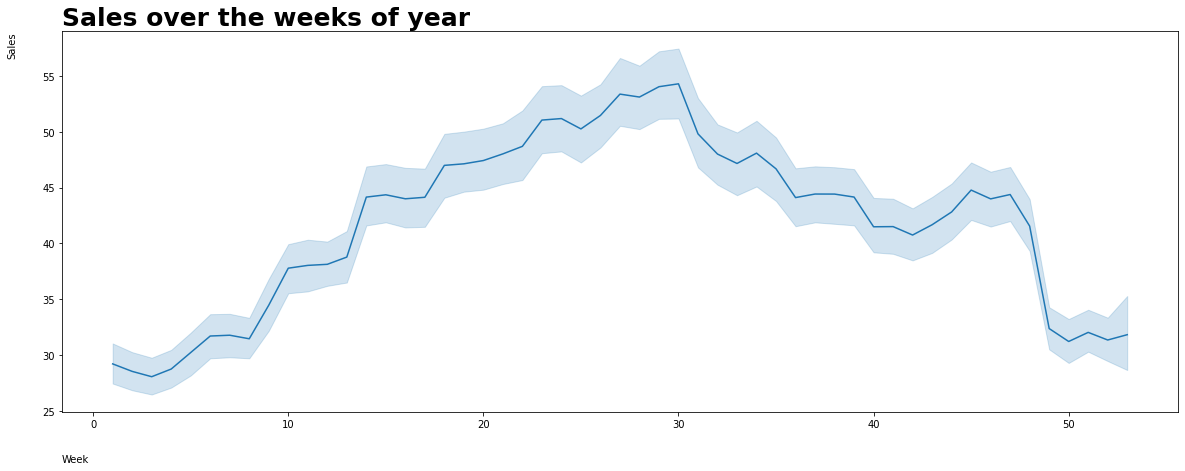

In [0]:
'''
plt.figure(figsize=(20, 7))
sns.lineplot(data=train2, x='weekofyear', y='sales')
plt.title('Sales over the weeks of year', fontsize=25, fontweight='bold', loc='left')
plt.xlabel('Week', loc='left', labelpad=25)
plt.ylabel('Sales', loc='top', labelpad=25)
plt.show()
'''

The weekly sales form the same pattern. Weeks around july present higher sales.

In [0]:
train2_grouped = train2.groupby('weekofyear').agg({'sales': 'sum'}).reset_index()

# Print the first few rows to check the data
#print(train2_grouped.head())

# Create the Plotly figure
fig = go.Figure()

# Add a line trace for the aggregated sales data
fig.add_trace(go.Scatter(
    x=train2_grouped['weekofyear'],  # Use the 'weekofyear' column for x-axis
    y=train2_grouped['sales'],  # Use the 'sales' column for y-axis
    mode='lines',
    name='Sales'
))

# Customize the layout
fig.update_layout(
    title='Sales-over-the-weeks-of-year',
    xaxis_title='Week of the Year',  # X-axis title
    yaxis_title='Sales',  # Y-axis title
    width=1200,
    height=400,
    title_x=0.05,  # Adjust the position of the title
    margin=dict(l=50, r=50, t=50, b=50)  # Add some margin around the plot
)

# Show the figure in the notebook or save to HTML
fig.show()  # Uncomment this to show in an interactive notebook environment

fig_html = pyo.plot(fig, output_type='div', include_plotlyjs=False)

# Output the Plotly figure to the API
restworkflowcontext.outPlotly(9, title="Sales over the week of the year", text=fig_html)

formatted_text = '''
<p> The weekly sales form the same pattern. Weeks around july present higher sales..</p>
'''
restworkflowcontext.outHTML(9, title="Observations on Sales over the week of the year", text=formatted_text)

message="75"
restworkflowcontext.outputProgress(9, title="Progress", progress=message)

Check the Input type..
There is a match
 And Input is string type.
Sending Message: {'text': 'Plotly.newPlot( @@d2dc9d49-f5a7-4587-8369-5b6ca6576869@@, [{@@mode@@:@@lines@@,@@name@@:@@Sales@@,@@x@@:[1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0,31.0,32.0,33.0,34.0,35.0,36.0,37.0,38.0,39.0,40.0,41.0,42.0,43.0,44.0,45.0,46.0,47.0,48.0,49.0,50.0,51.0,52.0,53.0],@@y@@:[7103,7197,7077,7250,7622,7994,8012,7932,8689,9523,9586,9610,9773,11125,11177,11087,11121,11840,11875,11949,12099,12269,12861,12895,12662,12965,13446,13380,13613,13678,12550,12095,11883,12116,11762,11114,11194,11193,11126,10456,10460,10270,10502,10790,11283,11085,11183,10471,8162,7871,8076,7622,2006],@@type@@:@@scatter@@}], {@@height@@:400,@@margin@@:{@@b@@:50,@@l@@:50,@@r@@:50,@@t@@:50},@@template@@:{@@data@@:{@@barpolar@@:[{@@marker@@:{@@line@@:{@@color@@:@@#E5ECF6@@,@@width@@:0.5},@@pattern@@:{@@fillmode@@:@@overlay@@,@@size@@:10,@@solidity@@:0.2}},@@type@@:@@barpolar@@}],@@bar@@:[{@@error_x@@:{@@color@@:@@#2a3f5f@@},@@error_y@@:{@@color@@:@@#2a3f5f@@},@@marker@@:{@@line@@:{@@color@@:@@#E5ECF6@@,@@width@@:0.5},@@pattern@@:{@@fillmode@@:@@overlay@@,@@size@@:10,@@solidity@@:0.2}},@@type@@:@@bar@@}],@@carpet@@:[{@@aaxis@@:{@@endlinecolor@@:@@#2a3f5f@@,@@gridcolor@@:@@white@@,@@linecolor@@:@@white@@,@@minorgridcolor@@:@@white@@,@@startlinecolor@@:@@#2a3f5f@@},@@baxis@@:{@@endlinecolor@@:@@#2a3f5f@@,@@gridcolor@@:@@white@@,@@linecolor@@:@@white@@,@@minorgridcolor@@:@@white@@,@@startlinecolor@@:@@#2a3f5f@@},@@type@@:@@carpet@@}],@@choropleth@@:[{@@colorbar@@:{@@outlinewidth@@:0,@@ticks@@:@@@@},@@type@@:@@choropleth@@}],@@contourcarpet@@:[{@@colorbar@@:{@@outlinewidth@@:0,@@ticks@@:@@@@},@@type@@:@@contourcarpet@@}],@@contour@@:[{@@colorbar@@:{@@outlinewidth@@:0,@@ticks@@:@@@@},@@colorscale@@:[[0.0,@@#0d0887@@],[0.1111111111111111,@@#46039f@@],[0.2222222222222222,@@#7201a8@@],[0.3333333333333333,@@#9c179e@@],[0.4444444444444444,@@#bd3786@@],[0.5555555555555556,@@#d8576b@@],[0.6666666666666666,@@#ed7953@@],[0.7777777777777778,@@#fb9f3a@@],[0.8888888888888888,@@#fdca26@@],[1.0,@@#f0f921@@]],@@type@@:@@contour@@}],@@heatmapgl@@:[{@@colorbar@@:{@@outlinewidth@@:0,@@ticks@@:@@@@},@@colorscale@@:[[0.0,@@#0d0887@@],[0.1111111111111111,@@#46039f@@],[0.2222222222222222,@@#7201a8@@],[0.3333333333333333,@@#9c179e@@],[0.4444444444444444,@@#bd3786@@],[0.5555555555555556,@@#d8576b@@],[0.6666666666666666,@@#ed7953@@],[0.7777777777777778,@@#fb9f3a@@],[0.8888888888888888,@@#fdca26@@],[1.0,@@#f0f921@@]],@@type@@:@@heatmapgl@@}],@@heatmap@@:[{@@colorbar@@:{@@outlinewidth@@:0,@@ticks@@:@@@@},@@colorscale@@:[[0.0,@@#0d0887@@],[0.1111111111111111,@@#46039f@@],[0.2222222222222222,@@#7201a8@@],[0.3333333333333333,@@#9c179e@@],[0.4444444444444444,@@#bd3786@@],[0.5555555555555556,@@#d8576b@@],[0.6666666666666666,@@#ed7953@@],[0.7777777777777778,@@#fb9f3a@@],[0.8888888888888888,@@#fdca26@@],[1.0,@@#f0f921@@]],@@type@@:@@heatmap@@}],@@histogram2dcontour@@:[{@@colorbar@@:{@@outlinewidth@@:0,@@ticks@@:@@@@},@@colorscale@@:[[0.0,@@#0d0887@@],[0.1111111111111111,@@#46039f@@],[0.2222222222222222,@@#7201a8@@],[0.3333333333333333,@@#9c179e@@],[0.4444444444444444,@@#bd3786@@],[0.5555555555555556,@@#d8576b@@],[0.6666666666666666,@@#ed7953@@],[0.7777777777777778,@@#fb9f3a@@],[0.8888888888888888,@@#fdca26@@],[1.0,@@#f0f921@@]],@@type@@:@@histogram2dcontour@@}],@@histogram2d@@:[{@@colorbar@@:{@@outlinewidth@@:0,@@ticks@@:@@@@},@@colorscale@@:[[0.0,@@#0d0887@@],[0.1111111111111111,@@#46039f@@],[0.2222222222222222,@@#7201a8@@],[0.3333333333333333,@@#9c179e@@],[0.4444444444444444,@@#bd3786@@],[0.5555555555555556,@@#d8576b@@],[0.6666666666666666,@@#ed7953@@],[0.7777777777777778,@@#fb9f3a@@],[0.8888888888888888,@@#fdca26@@],[1.0,@@#f0f921@@]],@@type@@:@@histogram2d@@}],@@histogram@@:[{@@marker@@:{@@pattern@@:{@@fillmode@@:@@overlay@@,@@size@@:10,@@solidity@@:0.2}},@@type@@:@@histogram@@}],@@mesh3d@@:[{@@colorbar@@:{@@outl

### Sales over the week

In [0]:
'''
plt.figure(figsize=(20, 7))
sns.lineplot(data=train2, x='dayofweek', y='sales')
plt.title('Sales over the week', fontsize=25, fontweight='bold', loc='left', pad=25)
plt.xlabel('Day', loc='left', labelpad=25)
plt.xticks(range(0, 7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.ylabel('Sales', loc='top', labelpad=25)   
plt.show()
'''
train2_grouped = train2.groupby('dayofweek').agg({'sales': 'sum'}).reset_index()

# Create the Plotly figure
fig = go.Figure()

# Add a line trace for the aggregated sales data
fig.add_trace(go.Scatter(
    x=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],  # Day names for x-axis
    y=train2_grouped['sales'],  # Use the 'sales' column for y-axis
    mode='lines',
    name='Sales'
))

# Customize the layout
fig.update_layout(
    title='Sales-over-the-week',
    xaxis_title='Day of the Week',  # X-axis title
    yaxis_title='Sales',  # Y-axis title
    width=1200,
    height=400,
    title_x=0.05,  # Adjust the position of the title
    xaxis=dict(
        tickmode='array',
        tickvals=train2_grouped['dayofweek'],  # Ensuring the tickvals match the days of the week
        ticktext=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    ),
    margin=dict(l=50, r=50, t=50, b=50)  # Add some margin around the plot
)

# Show the figure in the notebook or save to HTML
fig.show()  # Uncomment this to show in an interactive notebook environment

fig_html = pyo.plot(fig, output_type='div', include_plotlyjs=False)

# Output the Plotly figure to the API
restworkflowcontext.outPlotly(9, title="Sales over the week", text=fig_html)

formatted_text = '''
<p> The sales tend to increase throughout the week. Sunday presents the highest sales.</p>
'''
restworkflowcontext.outHTML(9, title="Observations on Sales over the week", text=formatted_text)

message="75"
restworkflowcontext.outputProgress(9, title="Progress", progress=message)

Check the Input type..
There is a match
 And Input is string type.
Sending Message: {'text': 'Plotly.newPlot( @@9058cf74-ec26-4eac-bda5-38cd8fc63ccd@@, [{@@mode@@:@@lines@@,@@name@@:@@Sales@@,@@x@@:[@@Monday@@,@@Tuesday@@,@@Wednesday@@,@@Thursday@@,@@Friday@@,@@Saturday@@,@@Sunday@@],@@y@@:[62377,73128,73052,77914,83869,88966,93374],@@type@@:@@scatter@@}], {@@height@@:400,@@margin@@:{@@b@@:50,@@l@@:50,@@r@@:50,@@t@@:50},@@template@@:{@@data@@:{@@barpolar@@:[{@@marker@@:{@@line@@:{@@color@@:@@#E5ECF6@@,@@width@@:0.5},@@pattern@@:{@@fillmode@@:@@overlay@@,@@size@@:10,@@solidity@@:0.2}},@@type@@:@@barpolar@@}],@@bar@@:[{@@error_x@@:{@@color@@:@@#2a3f5f@@},@@error_y@@:{@@color@@:@@#2a3f5f@@},@@marker@@:{@@line@@:{@@color@@:@@#E5ECF6@@,@@width@@:0.5},@@pattern@@:{@@fillmode@@:@@overlay@@,@@size@@:10,@@solidity@@:0.2}},@@type@@:@@bar@@}],@@carpet@@:[{@@aaxis@@:{@@endlinecolor@@:@@#2a3f5f@@,@@gridcolor@@:@@white@@,@@linecolor@@:@@white@@,@@minorgridcolor@@:@@white@@,@@startlinecolor@@:@@#2a3f5f@@},@@baxis@@:{@@endlinecolor@@:@@#2a3f5f@@,@@gridcolor@@:@@white@@,@@linecolor@@:@@white@@,@@minorgridcolor@@:@@white@@,@@startlinecolor@@:@@#2a3f5f@@},@@type@@:@@carpet@@}],@@choropleth@@:[{@@colorbar@@:{@@outlinewidth@@:0,@@ticks@@:@@@@},@@type@@:@@choropleth@@}],@@contourcarpet@@:[{@@colorbar@@:{@@outlinewidth@@:0,@@ticks@@:@@@@},@@type@@:@@contourcarpet@@}],@@contour@@:[{@@colorbar@@:{@@outlinewidth@@:0,@@ticks@@:@@@@},@@colorscale@@:[[0.0,@@#0d0887@@],[0.1111111111111111,@@#46039f@@],[0.2222222222222222,@@#7201a8@@],[0.3333333333333333,@@#9c179e@@],[0.4444444444444444,@@#bd3786@@],[0.5555555555555556,@@#d8576b@@],[0.6666666666666666,@@#ed7953@@],[0.7777777777777778,@@#fb9f3a@@],[0.8888888888888888,@@#fdca26@@],[1.0,@@#f0f921@@]],@@type@@:@@contour@@}],@@heatmapgl@@:[{@@colorbar@@:{@@outlinewidth@@:0,@@ticks@@:@@@@},@@colorscale@@:[[0.0,@@#0d0887@@],[0.1111111111111111,@@#46039f@@],[0.2222222222222222,@@#7201a8@@],[0.3333333333333333,@@#9c179e@@],[0.4444444444444444,@@#bd3786@@],[0.5555555555555556,@@#d8576b@@],[0.6666666666666666,@@#ed7953@@],[0.7777777777777778,@@#fb9f3a@@],[0.8888888888888888,@@#fdca26@@],[1.0,@@#f0f921@@]],@@type@@:@@heatmapgl@@}],@@heatmap@@:[{@@colorbar@@:{@@outlinewidth@@:0,@@ticks@@:@@@@},@@colorscale@@:[[0.0,@@#0d0887@@],[0.1111111111111111,@@#46039f@@],[0.2222222222222222,@@#7201a8@@],[0.3333333333333333,@@#9c179e@@],[0.4444444444444444,@@#bd3786@@],[0.5555555555555556,@@#d8576b@@],[0.6666666666666666,@@#ed7953@@],[0.7777777777777778,@@#fb9f3a@@],[0.8888888888888888,@@#fdca26@@],[1.0,@@#f0f921@@]],@@type@@:@@heatmap@@}],@@histogram2dcontour@@:[{@@colorbar@@:{@@outlinewidth@@:0,@@ticks@@:@@@@},@@colorscale@@:[[0.0,@@#0d0887@@],[0.1111111111111111,@@#46039f@@],[0.2222222222222222,@@#7201a8@@],[0.3333333333333333,@@#9c179e@@],[0.4444444444444444,@@#bd3786@@],[0.5555555555555556,@@#d8576b@@],[0.6666666666666666,@@#ed7953@@],[0.7777777777777778,@@#fb9f3a@@],[0.8888888888888888,@@#fdca26@@],[1.0,@@#f0f921@@]],@@type@@:@@histogram2dcontour@@}],@@histogram2d@@:[{@@colorbar@@:{@@outlinewidth@@:0,@@ticks@@:@@@@},@@colorscale@@:[[0.0,@@#0d0887@@],[0.1111111111111111,@@#46039f@@],[0.2222222222222222,@@#7201a8@@],[0.3333333333333333,@@#9c179e@@],[0.4444444444444444,@@#bd3786@@],[0.5555555555555556,@@#d8576b@@],[0.6666666666666666,@@#ed7953@@],[0.7777777777777778,@@#fb9f3a@@],[0.8888888888888888,@@#fdca26@@],[1.0,@@#f0f921@@]],@@type@@:@@histogram2d@@}],@@histogram@@:[{@@marker@@:{@@pattern@@:{@@fillmode@@:@@overlay@@,@@size@@:10,@@solidity@@:0.2}},@@type@@:@@histogram@@}],@@mesh3d@@:[{@@colorbar@@:{@@outlinewidth@@:0,@@ticks@@:@@@@},@@type@@:@@mesh3d@@}],@@parcoords@@:[{@@line@@:{@@colorbar@@:{@@outlinewidth@@:0,@@ticks@@:@@@@}},@@type@@:@@parcoords@@}],@@pie@@:[{@@automargin@@:true,@@type@@:@@pie@@}],@@scatter3d@@:[{@@line@@:{@@colorbar@@:{@@outlinewidth@@:0,@@ticks@@:@@@@}},@@marker@@:{@@colorbar@@:{@@outlinewidth@@:0,@@ticks@@:@@@@}},@@type@@:@@scatter3d@@}],@@scattercarpet@@:[{@@marker@@:{@@colorbar@@:{@@outlinewidth@@:0,

The sales tend to increase throughout the week. Sunday presents the highest sales.

### Sales over the month

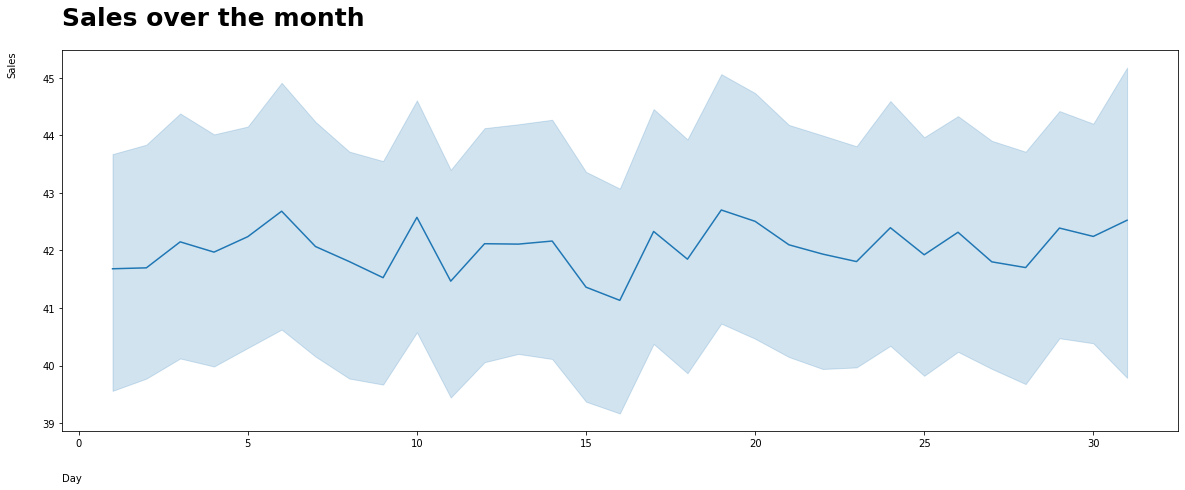

In [0]:
plt.figure(figsize=(20, 7))
sns.lineplot(data=train2, x='dayofmonth', y='sales')
plt.title('Sales over the month', fontsize=25, fontweight='bold', loc='left', pad=25)
plt.xlabel('Day', loc='left', labelpad=25)
plt.ylabel('Sales', loc='top', labelpad=25)   
plt.show()

It is noticeable that there is a peak in sales at the end of the month, especially in the 30th day.

### Sales per store

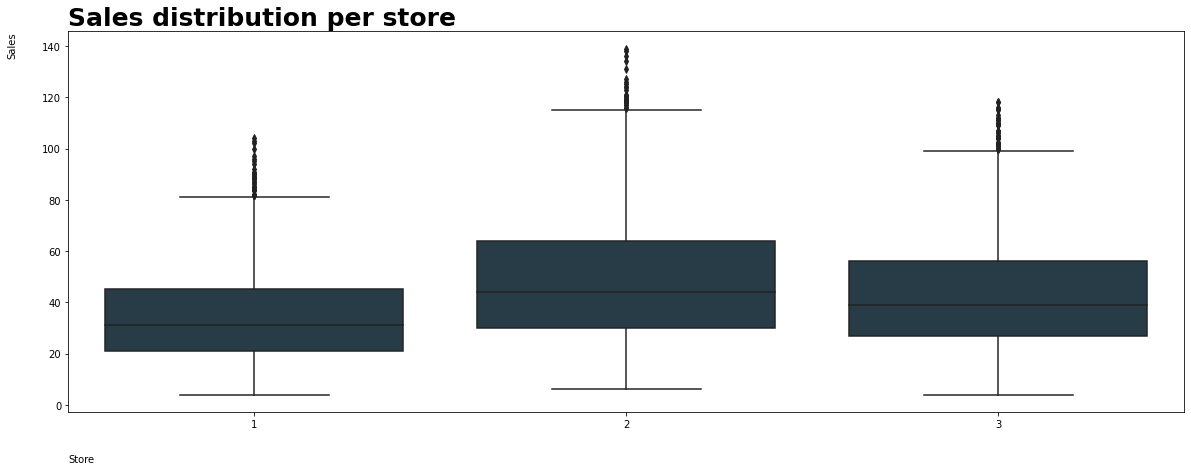

In [0]:
'''
plt.figure(figsize=(20, 7))
sns.boxplot(data=train2, x='store', y='sales', color='#233D4D')
plt.title('Sales distribution per store', fontsize=25, fontweight='bold', loc='left')
plt.xlabel('Store', labelpad=25, loc='left')
plt.ylabel('Sales', labelpad=25, loc='top')
plt.show()
'''

In [0]:
# Create the Plotly figure
fig = go.Figure()

# Add a box plot trace for the sales data
fig.add_trace(go.Box(
    x=train2['store'],  # Use the 'store' column for x-axis
    y=train2['sales'],  # Use the 'sales' column for y-axis
    name='Sales Distribution per Store',
    boxpoints='outliers',  # Show all the data points in the box plot
    marker_color='#233D4D'  # Set the marker color
))

# Customize the layout
fig.update_layout(
    title='Sales-distribution-per-store',
    xaxis_title='Store',  # X-axis title
    yaxis_title='Sales',  # Y-axis title
    width=1200,
    height=400,
    title_x=0.05,  # Adjust the position of the title
    margin=dict(l=50, r=50, t=50, b=50)  # Add some margin around the plot
)

# Get the HTML representation of the figure
fig_html = pyo.plot(fig, output_type='div', include_plotlyjs=False)


# Output the Plotly figure to the API
restworkflowcontext.outPlotly(9, title="Sales distribution per store", text=fig_html)


formatted_text = '''
<p><b>Key Takeaways:</b><br>
Store 3 appears to have the highest overall sales performance (highest median), but also shows more variability compared to other stores.<br>
Store 1 has the lowest median sales and a relatively narrow distribution, suggesting more consistent sales.<br>
Outliers are present for all stores, indicating potential factors worth investigating further.</p>
'''
restworkflowcontext.outHTML(9, title="Observation on Sales distribution per store", text=formatted_text)

message="80"
restworkflowcontext.outputProgress(9, title="Progress", progress=message)




Check the Input type..
There is a match
 And Input is string type.
Sending Message: {'text': 'Plotly.newPlot( @@90f7fdc5-9957-4e3b-b554-1fb785eddadf@@, [{@@boxpoints@@:@@outliers@@,@@marker@@:{@@color@@:@@#233D4D@@},@@name@@:@@Sales Distribution per Store@@,@@x@@:[1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2

In [0]:
message="100"
restworkflowcontext.outputProgress(9, title="Progress", progress=message)

message = "Job Execution Completed."
restworkflowcontext.outSuccess(9, title="Success", text=message)

Sending Message: {"progress": "100", "id": 9, "name": "Progress", "title": "Progress", "type": "progress", "resultType": 3, "visibility": "EXPANDED", "time": "Oct 10, 2024 06:32:14 PM"}
Not sending message to fire_notebook server as the post back URL is not http
Sending Message: {"text": "Job Execution Completed.", "id": 9, "name": "Success", "title": "Success", "type": "success", "resultType": 3, "visibility": "EXPANDED", "time": "Oct 10, 2024 06:32:14 PM"}
Not sending message to fire_notebook server as the post back URL is not http

# END